# Importing the dependancies (mentioned in the requirements.txt file)

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as mp
import torchvision.utils as vision_utils
import torchvision
from matplotlib.ticker import NullFormatter
import copy
from typing import Any, Callable, List, Optional, Type, Union

#Checking CUDA availability and setting the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
DEVICE

device(type='cpu')

# Label-Mapping function

In [ ]:
def filter_labels(data, target_labels, target_device=None):
    # Create a mapping of target labels to indices
    label_mapping = {label: idx for idx, label in enumerate(target_labels)}
    filtered_features, filtered_labels = [], []

    # Iterate through the dataset and keep only specified labels
    for feature, label in data:
        if label in label_mapping:
            filtered_features.append(feature)
            filtered_labels.append(label_mapping[label])

    # Stack features into a single tensor
    features_tensor = torch.stack(filtered_features)
    labels_tensor = torch.tensor(filtered_labels).long()

    # Move tensors to the specified device, if provided
    if target_device is not None:
        features_tensor = features_tensor.to(target_device)
        labels_tensor = labels_tensor.to(target_device)

    # Return the filtered dataset as a TensorDataset
    return torch.utils.data.TensorDataset(features_tensor, labels_tensor.view(-1, 1).float())


# Loading the MNIST data

In [ ]:
# Load the MNIST dataset for training and filter for binary labels (0 and 1)
train_data = MNIST('./data/mnist/', train=True, download=True, transform=transforms.ToTensor())
train_data = filter_labels(train_data, target_labels=[0, 1], target_device=DEVICE)

# Split the dataset into training and validation subsets
train_dataset, valid_dataset = torch.utils.data.random_split(train_data, [10000, 2665])

# Load the MNIST dataset for testing and filter for binary labels (0 and 1)
test_data = MNIST('./data/mnist/', train=False, download=True, transform=transforms.ToTensor())
test_data = filter_labels(test_data, target_labels=[0, 1], target_device=DEVICE)

# Create data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.1MB/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.23MB/s]


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.59MB/s]


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



In [ ]:
print(f"Training dataset length: {len(train_loader.dataset)}")
print(f"Valididation dataset length: {len(valid_loader.dataset)}")
print(f"Test dataset length: {len(test_loader.dataset)}")

Training dataset length: 10000
Valididation dataset length: 2665
Test dataset length: 2115


# Build interpolated dataset

In [ ]:
def display_samples(images, count):
    # Setup figure for plotting
    mp.figure(figsize=(10, 10), dpi=130)
    # Arrange images in a grid
    image_grid = vision_utils.make_grid(images[:count].cpu(), nrow=int(count/2), normalize=True, padding=1)
    # Display the grid of images
    mp.imshow(image_grid.permute(1, 2, 0), interpolation='nearest')
    # Remove ticks and axis labels
    mp.tick_params(axis='both', which='both', length=0)
    axis = mp.gca()
    axis.xaxis.set_major_formatter(NullFormatter())
    axis.yaxis.set_major_formatter(NullFormatter())
    # Show the figure
    mp.show()

def generate_interpolated_data(data_loader, max_image_pairs=500, interpolation_steps=150, target_device=torch.device('cpu')):
    # Extract tensors from the dataset
    test_images, test_labels = data_loader.dataset.tensors

    # Separate images by labels
    images_class_0 = test_images[test_labels.view(-1) == 0]
    images_class_1 = test_images[test_labels.view(-1) == 1]

    # Generate interpolation weights
    interpolation_weights = torch.tensor(np.linspace(0, 1, interpolation_steps)) * 3 - 1

    interpolated_images, weight_list = [], []

    # Create interpolations without computing gradients
    with torch.no_grad():
        for img_0, img_1 in zip(images_class_0[:max_image_pairs], images_class_1[:max_image_pairs]):
            for weight in interpolation_weights:
                blended_image = weight * img_1 + (1 - weight) * img_0
                interpolated_images.append(blended_image.cpu())
                weight_list.append(weight.item())

    # Stack the interpolated images and move to the target device
    interpolated_images_tensor = torch.stack(interpolated_images).to(target_device)

    return interpolated_images_tensor, weight_list


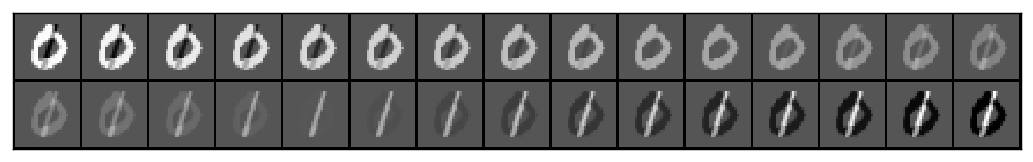

In [ ]:
img_cnt=30
X_test, weights_test = generate_interpolated_data(test_loader, max_image_pairs=1, interpolation_steps=img_cnt)
display_samples(X_test,img_cnt)

# Model

In [ ]:
class LeNet(nn.Module):
  def __init__(self, num_classes=10) -> None:
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.fc1 = nn.Linear(400, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)
    self.maxPool = nn.MaxPool2d(2,2)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.maxPool(F.relu(self.conv1(x)))
    x = self.maxPool(F.relu(self.conv2(x)))
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Training utils :-

# 1. Function for Computing accuracy across the batches

In [ ]:
@torch.no_grad()
def compute_accuracy(model, data_loader):
    # Set the model to evaluation mode to ensure layers like dropout and batch normalization behave correctly
    model.eval()

    correct_predictions = 0  # Count the number of correct predictions
    total_predictions = 0  # Keep track of the total number of predictions

    # Loop through the DataLoader to get batches of data
    for inputs, labels in data_loader:
        # Get the model's predictions by passing the inputs through the model
        raw_outputs = model(inputs)

        # Apply the sigmoid function to the raw outputs to get probabilities for class 1
        probabilities = torch.sigmoid(raw_outputs)

        # Compare the predicted probabilities to the 0.5 threshold and round them to 0 or 1
        predicted_classes = (probabilities > 0.5).float()

        # Check how many predictions were correct
        correct_predictions_batch = (predicted_classes == labels).sum()

        # Update the total count of correct predictions and total predictions
        correct_predictions += correct_predictions_batch.item()
        total_predictions += labels.size(0)

    # Calculate the accuracy as the ratio of correct predictions to total predictions
    accuracy = correct_predictions / total_predictions

    # Return the computed accuracy
    model.train()  # Set the model back to training mode
    return accuracy

# 2. Function to obtain random samples from the data loader

In [ ]:
def data_loader_to_cyclic_sampler(data_loader):
    data_iter = iter(data_loader)  # Create an iterator for the DataLoader

    def cyclic_sample():
        nonlocal data_iter
        try:
            # Attempt to fetch the next batch
            return next(data_iter)
        except StopIteration:
            # Restart the iterator when it is exhausted
            data_iter = iter(data_loader)
            return next(data_iter)

    return cyclic_sample

# 3.Function to calculate probabilities

In [ ]:
def compute_probabilities(model_stats):
    with torch.no_grad():  # Disable gradient computation for inference
        model_outputs = []  # Store outputs from all models

        for model in model_stats['all_models']:
            # Compute probabilities for the positive class
            # Move X_test to the same device as the model
            model_outputs.append(torch.sigmoid(model(X_test.to(model.conv1.weight.device))))

        # Average probabilities across all models
        avg_probabilities = sum(model_outputs) / len(model_outputs)

        # Concatenate probabilities for both classes
        final_probabilities = torch.cat((avg_probabilities, 1 - avg_probabilities), dim=1)

    return final_probabilities

# 4. Entropy_plotting func

In [ ]:
def visualize_entropy(uncertainty, time_steps):
    # Extract sorted unique time steps
    unique_times = sorted(set(time_steps))

    # Map each unique time step to an index
    time_to_index = {time: i for i, time in enumerate(unique_times)}

    # Initialize storage for entropy grouped by time step
    grouped_entropy = [[] for _ in range(len(unique_times))]

    # Group entropy values based on corresponding time steps
    for step, value in zip(time_steps, uncertainty):
        index = time_to_index[step]
        grouped_entropy[index].append(value)

    # Compute average entropy for each time step
    mean_entropy = [np.mean(values) for values in grouped_entropy]

    # Plotting the results
    fig, ax = mp.subplots(figsize=(4, 3), dpi=110)
    ax.grid()
    ax.set_xlabel("$t$")
    ax.set_ylabel("Uncertainty (Entropy)")
    ax.plot(unique_times, mean_entropy)


# 5.Ensemble accuracy for all the models

In [ ]:
@torch.no_grad()
def compute_ensemble_accuracy(models, data_loader):
    # Set all models to evaluation mode
    for model in models:
        model.eval()

    correct_predictions = []

    # Iterate over batches in the data loader
    for inputs, labels in data_loader:
        # Get predictions from all models
        predictions = [torch.sigmoid(model(inputs)) for model in models]

        # Stack the predictions and take the average
        averaged_predictions = torch.stack(predictions, dim=0).mean(dim=0)

        # Compare the averaged predictions with the true labels
        correct_predictions.append((averaged_predictions > 0.5) == labels)

    # Concatenate the results and compute final accuracy
    correct_predictions = torch.cat(correct_predictions)
    accuracy = torch.sum(correct_predictions) / len(correct_predictions)

    return accuracy.item()


# 6.Ensemble learning

In [ ]:
def sequential_training(num_models, train_data_loader, validation_loader, test_loader, perturbation_loader,
                        penalty_factor=0.01, max_epochs=25, apply_diversity_regulation=True, learning_rate=0.0001,
                        weight_decay_rate=0.000002):

    # Initialize models
    model_list = [LeNet(num_classes=1).to(DEVICE) for _ in range(num_models)]

    training_statistics = {f"model_{i+1}": {"accuracy": [], "training_loss": [], "diversity_loss": []} for i in range(len(model_list))}
    lrr=learning_rate/2;
    for model_idx, model in enumerate(model_list):
        #doubling lr..just for fun
        lrr*=2
        # Initialize optimizer for the current model
        optimizer = torch.optim.AdamW(model.parameters(), lr=lrr, weight_decay=weight_decay_rate)

        perturbation_sampler = data_loader_to_cyclic_sampler(perturbation_loader)

        for epoch in range(max_epochs):
            for iteration, (inputs, labels) in enumerate(train_data_loader):

                # Get a perturbed version of the data
                perturbed_inputs, _ = perturbation_sampler()

                # Calculate the binary cross-entropy loss
                model_output = model(inputs)
                training_loss = F.binary_cross_entropy_with_logits(model_output, labels)

                # Diversity regularization (only for models after the first)
                if apply_diversity_regulation and model_idx != 0:
                    diversity_loss = []
                    with torch.no_grad():
                        predictions_from_previous_models = [torch.sigmoid(m(perturbed_inputs)) for m in model_list[:model_idx]]
                    current_model_prediction = torch.sigmoid(model(perturbed_inputs))
                    for prediction in predictions_from_previous_models:
                        divergence_loss = - ((1. - prediction) * current_model_prediction + prediction * (1. - current_model_prediction) + 1e-7).log().mean()
                        diversity_loss.append(divergence_loss)
                else:
                    diversity_loss = [torch.tensor([0]).to(DEVICE)]

                # Calculate the total loss with the diversity penalty
                total_diversity_loss = sum(diversity_loss) / len(diversity_loss)
                total_loss = training_loss + penalty_factor * total_diversity_loss

                # Backpropagate and optimize
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                # Logging and tracking
                if (iteration + epoch * len(train_data_loader)) % 100 == 0:
                    total_iterations = iteration + epoch * len(train_data_loader)
                    log_message = f"[model_{model_idx+1}] {epoch}/{total_iterations} [train] loss: {training_loss.item():.2f} diversity_loss: {total_diversity_loss.item():.2f} "
                    training_statistics[f"model_{model_idx+1}"]["training_loss"].append((total_iterations, training_loss.item()))
                    training_statistics[f"model_{model_idx+1}"]["diversity_loss"].append((total_iterations, total_diversity_loss.item()))
                    accuracy = compute_accuracy(model, validation_loader)
                    training_statistics[f"model_{model_idx+1}"]["accuracy"].append((total_iterations, accuracy))
                    log_message += f" accuracy: {accuracy:.2f}"
                    print(log_message)

                iteration += 1

    training_statistics['all_models'] = model_list

    return training_statistics


# Building Perturbation Dataset

In [ ]:
# Load the MNIST dataset and keep only specific labels
mnist_data = MNIST('./data/mnist/', train=True, download=True, transform=transforms.ToTensor())
mnist_data = filter_labels(mnist_data, target_labels=[2, 3, 4, 5, 6, 7, 8, 9], target_device=DEVICE)#All except 0 and 1

# Extract features (X) and labels (Y) from the dataset
features, labels = mnist_data.tensors

# Apply padding and random crop to the images for perturbation
crop_transform = torchvision.transforms.RandomCrop(30)
features = torchvision.transforms.functional.pad(features, padding=(12, 12), fill=0)
perturbed_features = torch.cat([crop_transform(image.view(1, 1, 52, 52)) for image in features])

# Create a new dataset with the perturbed images
perturbed_dataset = TensorDataset(perturbed_features, labels)

# Create a DataLoader for the perturbed dataset
perturbed_loader = DataLoader(perturbed_dataset, batch_size=256, shuffle=True)

# Print the length of the perturbations dataset
print(f"Perturbations length: {len(perturbed_loader.dataset)}")


Perturbations length: 47335


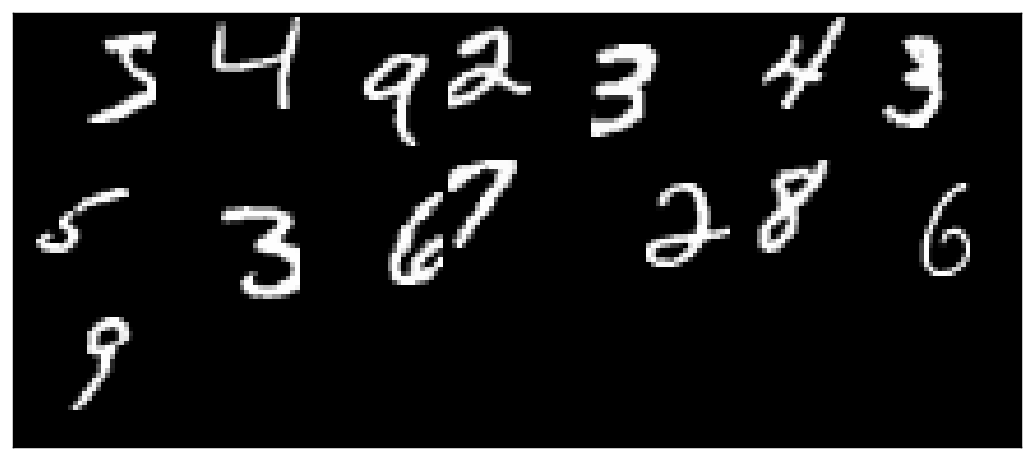

In [ ]:
#Visualize a few sample images from the perturbed dataset
display_samples(perturbed_features,count=15)

# Deep-ensemble training

In [ ]:
ensemble_entropy = []
ensemble_accuracies = []

# Run the ensemble training process 5 times
for _ in range(2):
    # Train the models sequentially
    training_stats = sequential_training(3, train_loader, valid_loader, test_loader, perturbed_loader, penalty_factor=0.001, max_epochs=5, learning_rate=0.0001)

    # Compute the accuracy of the ensemble on the test dataset
    ensemble_accuracy = compute_ensemble_accuracy(training_stats['all_models'], test_loader)
    ensemble_accuracies.append(ensemble_accuracy)
    print(f"Ensemble Accuracy: {ensemble_accuracies[-1]:.4f}")

    # Get predicted probabilities from the trained ensemble
    probas = compute_probabilities(training_stats)

    with torch.no_grad():
        # Compute entropy for the predicted probabilities
        entropy_values = (-(probas * (probas + 1e-8).log())).sum(dim=1).cpu()
        ensemble_entropy.append(entropy_values)

# After collecting entropy for all runs, compute the average entropy
with torch.no_grad():
    average_entropy = torch.stack(ensemble_entropy, dim=0)
    average_entropy = average_entropy.mean(dim=0)


[model_1] 0/0 [train] loss: 0.69 diversity_loss: 0.00  accuracy: 0.47
[model_1] 1/100 [train] loss: 0.37 diversity_loss: 0.00  accuracy: 0.99
[model_1] 2/200 [train] loss: 0.03 diversity_loss: 0.00  accuracy: 0.99
[model_1] 3/300 [train] loss: 0.01 diversity_loss: 0.00  accuracy: 1.00
[model_2] 0/0 [train] loss: 0.70 diversity_loss: 0.69  accuracy: 0.53
[model_2] 1/100 [train] loss: 0.05 diversity_loss: 1.53  accuracy: 0.99
[model_2] 2/200 [train] loss: 0.00 diversity_loss: 1.97  accuracy: 1.00
[model_2] 3/300 [train] loss: 0.00 diversity_loss: 1.60  accuracy: 1.00
[model_3] 0/0 [train] loss: 0.69 diversity_loss: 0.69  accuracy: 0.53
[model_3] 1/100 [train] loss: 0.01 diversity_loss: 1.39  accuracy: 1.00
[model_3] 2/200 [train] loss: 0.00 diversity_loss: 1.35  accuracy: 1.00
[model_3] 3/300 [train] loss: 0.00 diversity_loss: 1.60  accuracy: 1.00
Ensemble Accuracy: 0.9986
[model_1] 0/0 [train] loss: 0.69 diversity_loss: 0.00  accuracy: 0.47
[model_1] 1/100 [train] loss: 0.26 diversity_l

Test Ensemble Accuracy: 0.9988 +/- 0.0002


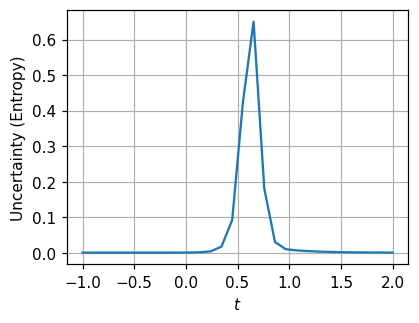

In [ ]:
# Plot the entropy values
visualize_entropy(average_entropy, weights_test)

# Print the final ensemble accuracy statistics
mean_accuracy = np.mean(ensemble_accuracies)
std_accuracy = np.std(ensemble_accuracies)
print(f"Test Ensemble Accuracy: {mean_accuracy:.4f} +/- {std_accuracy:.4f}")